# 결과
result|konlpy|1st|2nd|3rd
---|---|---|---|---
train_loss|.|0.0374|0.0403|0.0557
train_accuracy|.|0.9907|0.9902|0.9857
val_loss|.|0.9632|0.9516|0.8000
val_accuracy|.|0.8050|0.8067|0.8050
test_loss|1.0336|0.9898|0.9814|0.8167
test_accuracy|0.8102|0.8007|0.8021|0.8027
  
    
    
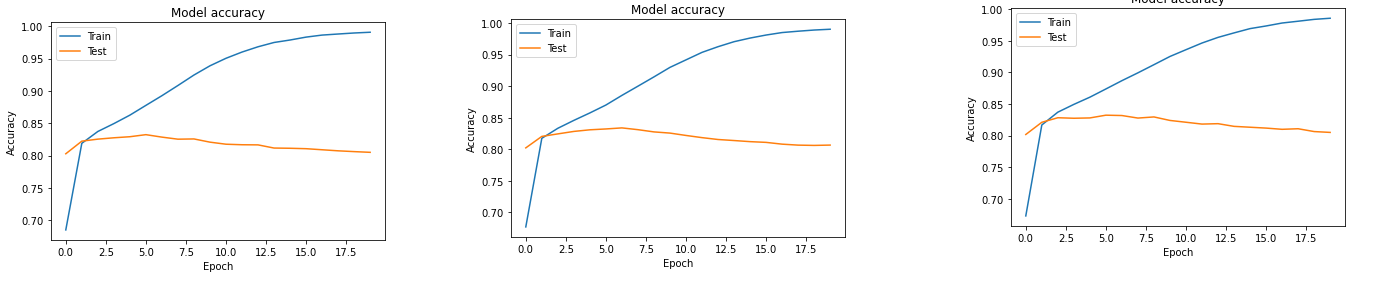

# 학습하면서 생각한 점
  - 자연어 처리부터는 어려워짐
    - 어렵게 느껴지는 이유 : Exploration, Fundamental을 학습하면서 제대로 이해하지 않고 넘어갔기 때문
    - 다시 처음부터 보는 것은 시간이 많이 소요될 듯
    - 코드를 이해하려 노력하면서 학습은 하였지만 아직 잘 모르겠음.
    

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/work/project/explorationData/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/work/project/explorationData/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print("Total train data : ", len(train_data))

Total train data :  150000


In [3]:
# 데이터의 중복이 있는지 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [4]:
# 중복된 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [5]:
print("Total train data : ", len(train_data))

Total train data :  146183


In [6]:
# label별 data 수량 : (0: 73342, 1: 72841)

print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [7]:
# null 값을 가진 샘플 제거

train_data = train_data.dropna(how='any')  # null 값이 존재하는 행 제거
print(train_data.isnull().values.any())  # null 값이 아직 존재하는지 재확인

False


In [8]:
train_data.shape

(146182, 3)

In [9]:
# 한글과 공백을 제외하고 모두 제거

train_data['document'] = train_data['document'].str.replace("[^ㄱ-하-ㅣ가-힣 ]", "")

train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [10]:
# 한글 제외한 글자를 제거했기에 null이 생겼을 수 있으므로 다시 확인하여 제거

train_data['document'].replace('', np.nan, inplace=True)  # 공백만 있는 열 : null 로 처리
print(train_data.isnull().sum())

train_data.loc[train_data.document.isnull()].head()

id            0
document    363
label         0
dtype: int64


,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [11]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145819


In [12]:
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [13]:
# test data에도 동일한 전처리 진행

test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-하-ㅣ가-힣 ]", "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('After preprocessor : ', len(test_data))

After preprocessor :  49000


SentencePiece

In [14]:
raw_train = train_data.copy()
raw_test = test_data.copy()

In [15]:
raw_train, raw_test

(              id                                           document  label
 0        9976970                                  아 더빙 진짜 짜증나네요 목소리      0
 1        3819312                         흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1
 2       10265843                                  너무재밓었다그래서보는것을추천한다      0
 3        9045019                          교도소 이야기구먼 솔직히 재미는 없다평점 조정      0
 4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...      1
 ...          ...                                                ...    ...
 149995   6222902                                    인간이 문제지 소는 뭔죄인가      0
 149996   8549745                                         평점이 너무 낮아서      1
 149997   9311800                      이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다      0
 149998   2376369                         청춘 영화의 최고봉방황과 우울했던 날들의 자화상      1
 149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0
 
 [145819 rows x 3 columns],
             id                                    documen

In [16]:
y_train = raw_train['label']
y_test = raw_test['label']

In [17]:
type(raw_train)

pandas.core.frame.DataFrame

문장의 최단 길이:  1
문장의 최장 길이:  140
문장의 평균 길이:  33


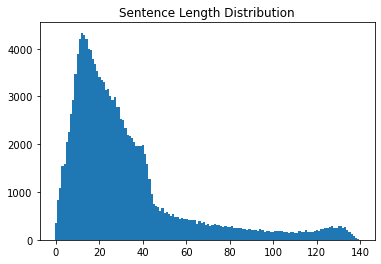

In [18]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw_train['document']:
    length = len(sen)
    if min_len > length:
        min_len = length
    if max_len < length:
        max_len = length
        
    sum_len += length
    
print('문장의 최단 길이: ', min_len)
print('문장의 최장 길이: ', max_len)
print('문장의 평균 길이: ', sum_len // len(raw_train['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw_train['document']:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

문장의 최단 길이:  1
문장의 최장 길이:  140
문장의 평균 길이:  32


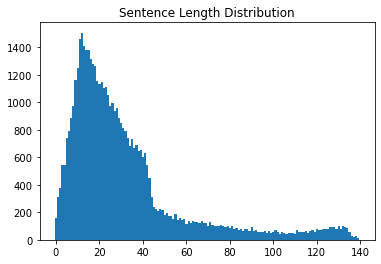

In [19]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw_test['document']:
    length = len(sen)
    if min_len > length:
        min_len = length
    if max_len < length:
        max_len = length
        
    sum_len += length
    
print('문장의 최단 길이: ', min_len)
print('문장의 최장 길이: ', max_len)
print('문장의 평균 길이: ', sum_len // len(raw_test['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw_test['document']:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

In [20]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

In [31]:
def naverMovie(x_train, y_train, x_test, y_test):
    splt = int(len(x_train) * 0.2)
    # print("validation data : ", splt)
    x_val = x_train[:splt]   
    y_val = y_train[:splt]

    # validation set을 제외한 나머지 15000건
    partial_x_train = x_train[splt:]  
    partial_y_train = y_train[splt:]

    word_vector_dim = 36  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

    model = keras.Sequential()

    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    print(model.summary())


    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=1024,
                        validation_data=(x_val, y_val), verbose=1)

    # 테스트 모델 사용하기
    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)

    print('')
    print('loss : ' + str(loss_and_metrics[0]))
    print('accuray : ' + str(loss_and_metrics[1]))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [21]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
x_train = []
for x_tr in raw_train['document']:
    x_train.append(s.EncodeAsIds(x_tr))
    
x_test = []
for x_te in raw_test['document']:
    x_test.append(s.EncodeAsIds(x_te))


In [22]:
print(x_train[10])

[4, 0, 20, 377, 152, 78, 11, 0, 160, 167, 4849, 0, 160]


In [23]:
print(len(x_train), len(y_train), len(x_test), len(y_test))
print(type(x_train))

145819 145819 49000 49000
<class 'list'>


In [32]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        padding='post', # 혹은 'pre'
)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       padding='post', # 혹은 'pre'
)

print(x_train.shape)

(145819, 135)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 36)          288000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          4048      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

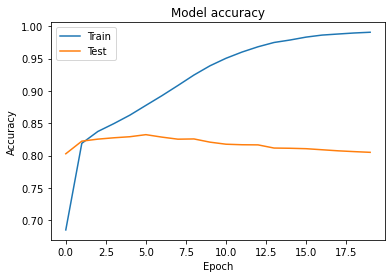

In [33]:
naverMovie(x_train, y_train, x_test, y_test)

In [34]:
import tensorflow as tf 

def sp_tokenize(corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor
#     return tensor, word_index, index_word

In [37]:
x_train_sp = sp_tokenize(raw_train['document'])
x_test_sp = sp_tokenize(raw_test['document'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 36)          288000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          4048      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

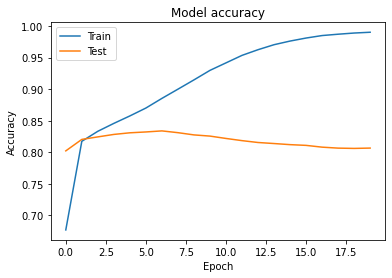

In [38]:
naverMovie(x_train_sp, y_train, x_test_sp, y_test)

In [72]:
%%time
import sentencepiece as spm

input_file = temp_file = os.getenv('HOME')+'/work/project/explorationData/sentiment_classification/ratings_train.txt'
vocab_size = 32000
model_name = 'subword_tokenizer_kor'
model_type = 'bpe'
#user_defined_symbols = '[PAD],[UNK],[CLS],[SEP],[MASK],[UNK1],[UNK2],[UNK3],[UNK4],[UNK5]'

input_argument = '--input=%s --model_prefix=%s --vocab_size=%s --model_type=%s'
cmd = input_argument%(input_file, model_name, vocab_size, model_type)

spm.SentencePieceTrainer.Train(cmd)

CPU times: user 1min 21s, sys: 441 ms, total: 1min 22s
Wall time: 1min 21s


In [73]:
x_train_sp = sp_tokenize(raw_train['document'])
x_test_sp = sp_tokenize(raw_test['document'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 36)          1152000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          4048      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

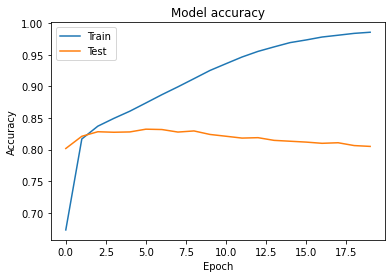

In [74]:
naverMovie(x_train_sp, y_train, x_test_sp, y_test)

새롭게 작성할려 했지만 계속 오류발생하여 포기

In [66]:
# templates= '--input={} \
# --pad_id={} \
# --bos_id={} \
# --eos_id={} \
# --unk_id={} \
# --model_prefix={} \
# --vocab_size={} \
# --character_coverage={} \
# --model_type={}'


# train_input_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
# pad_id=0  #<pad> token을 0으로 설정
# vocab_size = 20000 # vocab 사이즈
# prefix = 'korean_spm' # 저장될 tokenizer 모델에 붙는 이름
# bos_id=1 #<start> token을 1으로 설정
# eos_id=2 #<end> token을 2으로 설정
# unk_id=3 #<unknown> token을 3으로 설정
# character_coverage = 1.0 # to reduce character set 
# model_type ='bpe' # Choose from unigram (default), bpe, char, or word


# cmd = templates.format(train_input_file,
#                 pad_id,
#                 bos_id,
#                 eos_id,
#                 unk_id,
#                 prefix,
#                 vocab_size,
#                 character_coverage,
#                 model_type)

In [67]:
# !ls -l korean_spm*

-rw-rw-r-- 1 aiffel aiffel 376897 Apr 20 23:55 korean_spm.model
-rw-rw-r-- 1 aiffel aiffel 146388 Apr 20 23:55 korean_spm.vocab


In [68]:
# temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
# vocab_size = 20000
# model_type = 'bpe'
# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=korean_spm --vocab_size={} \
#     --model_type={}'.format(temp_file, vocab_size, model_type)    
# )


In [70]:
#spm.SentencePieceTrainer.Train(cmd)

In [46]:
# s = spm.SentencePieceProcessor()
# s.Load('korean_spm.model')

In [ ]:
# x_train_sp = sp_tokenize(raw_train['document'])
# x_test_sp = sp_tokenize(raw_test['document'])

In [ ]:
# naverMovie(x_train_sp, y_train, x_test_sp, y_test)